In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot
!pip install keras_applications

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [13]:
EPOCHS = 30
BS = 40
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 201

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [5]:
vgg_notop = VGGFace(model='senet50', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1

batch_norm_indices = [2, 6, 9, 12, 21, 25, 28, 31, 42, 45, 48, 59, 62, 65, 74, 78, 81, 84, 95, 98, 101, 112, 115, 118, 129, 132, 135, 144, 148, 151, 154, 165, 168, 171, 182, 185, 188, 199, 202, 205, 216, 219, 222, 233, 236, 239, 248, 252, 255, 258, 269, 272, 275]    
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
# plot_model(model, to_file='model2.png', show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


104947712/104944616 [==============================] - 1s 0us/step


In [6]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/My Drive/Colab Notebooks/dataset/train.zip' -d train
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/My Drive/Colab Notebooks/dataset/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/My Drive/Colab Notebooks/dataset/test-private.zip' -d test

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [8]:
%%bash
root='/content/train/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

0 angry: 3995
1 disgust: 436
2 fear: 4097
3 happy: 7215
4 sad: 4830
5 surprise: 3171
6 neutral: 4965


In [9]:
train_generator  = get_datagen('/content/train', True)
dev_generator    = get_datagen('/content/dev')
test_generator  = get_datagen('/content/test')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [14]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    #steps_per_epoch=28709// BS,
    #validation_steps=3509 // BS,
    shuffle=True,
    epochs=30,
    callbacks=[rlrop],
    use_multiprocessing=True,
)

Epoch 1/30
575/575 [==============================] - 379s 659ms/step - loss: 1.9254 - accuracy: 0.2290 - val_loss: 1.8882 - val_accuracy: 0.2494
Epoch 2/30
575/575 [==============================] - 369s 642ms/step - loss: 1.4897 - accuracy: 0.3968 - val_loss: 1.5549 - val_accuracy: 0.4093
Epoch 3/30
575/575 [==============================] - 368s 641ms/step - loss: 1.2324 - accuracy: 0.5211 - val_loss: 1.1569 - val_accuracy: 0.5673
Epoch 4/30
575/575 [==============================] - 371s 645ms/step - loss: 1.1320 - accuracy: 0.5748 - val_loss: 0.8930 - val_accuracy: 0.6085
Epoch 5/30
575/575 [==============================] - 373s 649ms/step - loss: 1.0513 - accuracy: 0.6147 - val_loss: 0.9614 - val_accuracy: 0.6080
Epoch 6/30
575/575 [==============================] - 373s 649ms/step - loss: 0.9986 - accuracy: 0.6389 - val_loss: 1.0660 - val_accuracy: 0.6342
Epoch 7/30
575/575 [==============================] - 376s 653ms/step - loss: 0.9591 - accuracy: 0.6521 - val_loss: 0.8366 -

In [15]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.6616274118423462, 0.7015441060066223]


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


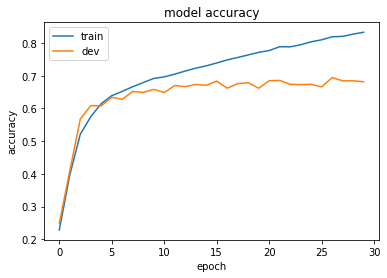

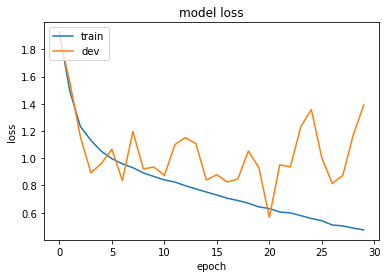

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [18]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/Colab Notebooks/models/' + 'SENET50' + epoch_str + test_acc + '.h5')